# 1. Dnipro regions locations

## Get names from wiki

In [1]:
import requests
from bs4 import BeautifulSoup

In [3]:
content = requests.get('https://en.wikipedia.org/wiki/Dnipro')
parser = BeautifulSoup(content.text, 'html.parser')

In [4]:
regions_td = parser.body.find_all("table", class_ = "wikitable")[0].select('tr')

In [6]:
dnipro_regions = [element.select('td')[1].text.replace('\n', '') for element in regions_td[1:]]

In [7]:
dnipro_regions

['Amur-Nyzhnodniprovskyi',
 'Shevchenkivskyi',
 'Sobornyi',
 'Industrialnyi',
 'Tsentralnyi',
 'Chechelivskyi',
 'Novokodatskyi',
 'Samarskyi']

In [8]:
import pandas as pd

In [9]:
dnipro_regions = pd.DataFrame({'Region' : dnipro_regions})

In [10]:
dnipro_regions

,Region
0,Amur-Nyzhnodniprovskyi
1,Shevchenkivskyi
2,Sobornyi
3,Industrialnyi
4,Tsentralnyi
5,Chechelivskyi
6,Novokodatskyi
7,Samarskyi


## Get city-regions locations with geopy

In [11]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [12]:
geolocator = Nominatim(user_agent="dnipro",timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)

In [14]:
longitudes = []
latitudes = []
for region in dnipro_regions['Region']:
    location = geocode('{}, Dnipro'.format(region))
    longitudes.append(location.longitude)
    latitudes.append(location.latitude)

In [16]:
dnipro_regions['Longitude'] = longitudes
dnipro_regions['Latitude'] = latitudes
dnipro_regions

,Region,Longitude,Latitude
0,Amur-Nyzhnodniprovskyi,35.041783,48.494564
1,Shevchenkivskyi,35.041771,48.468022
2,Sobornyi,35.058700,48.463425
3,Industrialnyi,35.078433,48.521464
4,Tsentralnyi,35.024010,48.459391
5,Chechelivskyi,34.981957,48.438557
6,Novokodatskyi,34.946035,48.485689
7,Samarskyi,35.158380,48.534687


# 2. Get cafes and shops details with Foursquare

In [19]:
CLIENT_ID = 'H2SID3VSTK5L101KYA3NVCRHFESPHCYIULK5CK3PGI1GGJ1D' # your Foursquare ID
CLIENT_SECRET = 'NKCDE13L2NX5IWWD5MSCRJH0GIFL5DJWGBUVFQFIVHDXOBF5' # your Foursquare Secret
VERSION = '20200128' # Foursquare API version

## 2.1. Get venues

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
               CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, 3000, 200)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.extend([
            [name, v['venue']['name'], v['venue']['id'],
            v['venue']['location']['lat'], v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']]
        for v in results])

    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Region', 'Venue', 'Venue ID', 'Venue Latitude', 'Venue Longitude', 'Venue Primary Category']
    
    return(nearby_venues)

In [32]:
dnipro_venues = getNearbyVenues(names=dnipro_regions['Region'],
                                latitudes=dnipro_regions['Latitude'],
                                longitudes=dnipro_regions['Longitude']
                                )

In [33]:
dnipro_venues.head()

,Region,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Primary Category
0,Amur-Nyzhnodniprovskyi,"Набережна на ж/м ""Сонячний""",4ead591a490170218c3e8eac,48.482077,35.064039,Waterfront
1,Amur-Nyzhnodniprovskyi,Джайпур,4e75e0861495be51714f2764,48.474490,35.028832,Gym / Fitness Center
2,Amur-Nyzhnodniprovskyi,Dance Republic,55a7a750498e39b5deec0a05,48.477264,35.024195,Dance Studio
3,Amur-Nyzhnodniprovskyi,Лазерхаус,5502f0e7498e26f68f81b356,48.470317,35.043921,Health & Beauty Service
4,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,48.483839,35.063883,Supermarket


In [35]:
dnipro_venues.shape

(571, 6)

In [36]:
venues_filter_food = ['Supermarket', 'French Restaurant', 'Coffee Shop', 'Modern European Restaurant', 'Sushi Restaurant',
                      'Fast Food Restaurant', 'Grocery Store', 'Italian Restaurant', 'Café', 'Beer Store', 'BBQ Joint',
                      'Seafood Restaurant', 'Caucasian Restaurant', 'Restaurant', 'Bakery', 'Comfort Food Restaurant',
                      'Pizza Place', 'Bar', 'Burger Joint', 'Dessert Shop', 'Tea Room', 'Cocktail Bar',
                      'Vegetarian / Vegan Restaurant','Irish Pub', 'Soup Place', 'Pub', 'Eastern European Restaurant',
                      'Gastropub', 'Ramen Restaurant', 'Food Court', 'Middle Eastern Restaurant', 'Food Truck',
                      'Theme Restaurant', 'Juice Bar', 'Asian Restaurant', 'Ukrainian Restaurant', 'Food & Drink Shop']

In [37]:
dnipro_venues_food = dnipro_venues.loc[dnipro_venues['Venue Primary Category'].isin(venues_filter_food)].drop_duplicates(subset = ['Venue ID'])

In [39]:
dnipro_venues_food.head()

,Region,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Primary Category
4,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,48.483839,35.063883,Supermarket
6,Amur-Nyzhnodniprovskyi,Pa-Si-Ju,558cfeb5498e6a17da7dfe6f,48.473249,35.029125,French Restaurant
11,Amur-Nyzhnodniprovskyi,HAVE Coffee,5a2fa09e69e77b22f361c493,48.469386,35.038928,Coffee Shop
13,Amur-Nyzhnodniprovskyi,Суши Набухико,5691301f498e3250c1f2ac16,48.469579,35.052557,Sushi Restaurant
14,Amur-Nyzhnodniprovskyi,Confetti | Конфетти,5bbefb002aff31002b5f9d9b,48.483092,35.063147,Modern European Restaurant


In [42]:
dnipro_venues_food.shape

(165, 6)

In [41]:
dnipro_venues_food = dnipro_venues_food.reset_index(drop=True)

## 2.2. Get venues info

In [45]:
import numpy as np

In [43]:
def getVenuesDetails(ids):
    venues_list=[]
    for venue_id in ids:
        url_venue = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                    venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        venue_results = requests.get(url_venue).json()["response"]['venue']
        
        venues_list.append([
            venue_results['location']['formattedAddress'],
            [el['name'] for el in venue_results['categories']],
            venue_results['likes']['count'] if 'likes' in venue_results else 0, 
            venue_results['rating'] if 'rating' in venue_results else 0,
            venue_results['hours']['isOpen'] if 'hours' in venue_results else np.nan
        ])

    venues_table = pd.DataFrame(venues_list)
    venues_table.columns = ['Venue Address', 'Venue Categories', 'Venue Likes', 'Venue Rating', 'Venue Is Open']
    
    return venues_table

In [46]:
venues_table = getVenuesDetails(dnipro_venues_food['Venue ID'].values)

In [47]:
dnipro_venues_food = pd.concat([dnipro_venues_food, venues_table], axis=1, join='outer')

In [48]:
dnipro_venues_food.head()

,Region,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Primary Category,Venue Address,Venue Categories,Venue Likes,Venue Rating,Venue Is Open
0,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,48.483839,35.063883,Supermarket,"[ТРЦ ""Вавілон"" (вул. Маршала Малиновського, 2)...","[Supermarket, Grocery Store]",374,7.9,False
1,Amur-Nyzhnodniprovskyi,Pa-Si-Ju,558cfeb5498e6a17da7dfe6f,48.473249,35.029125,French Restaurant,"[просп. Дмитра Яворницького, 90, Дніпро, Україна]",[French Restaurant],231,8.4,False
2,Amur-Nyzhnodniprovskyi,HAVE Coffee,5a2fa09e69e77b22f361c493,48.469386,35.038928,Coffee Shop,"[просп. Дмитра Яворницького, 70а (вул. Юліуша ...",[Coffee Shop],80,8.4,False
3,Amur-Nyzhnodniprovskyi,Суши Набухико,5691301f498e3250c1f2ac16,48.469579,35.052557,Sushi Restaurant,"[вул. Січеславська Набережна, 31-А, Дніпро, Ук...",[Sushi Restaurant],42,8.2,False
4,Amur-Nyzhnodniprovskyi,Confetti | Конфетти,5bbefb002aff31002b5f9d9b,48.483092,35.063147,Modern European Restaurant,"[ул. Малиновского, 2, Дніпро, Україна]",[Modern European Restaurant],8,7.5,NaN


In [58]:
dnipro_venues_food.shape

(165, 11)

# 3. Visualize cafes and shops with folium

In [50]:
import folium

In [53]:
map_venues_food = folium.Map(location=[dnipro_regions.iloc[0, 2], dnipro_regions.iloc[0, 1]], zoom_start=12)

import matplotlib.cm as cm
import matplotlib.colors as colors

colors_array = cm.rainbow(np.linspace(0, 1, dnipro_regions.shape[0]))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, name, region in zip(dnipro_venues_food['Venue Latitude'],
                                  dnipro_venues_food['Venue Longitude'],
                                  dnipro_venues_food['Venue'],
                                  dnipro_venues_food['Region']):
    label = folium.Popup('{}, {}'.format(name, region), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color=rainbow[dnipro_regions.index[dnipro_regions['Region'] == region].tolist()[0]],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues_food)

In [54]:
map_venues_food

# 4. Use the data

## Number of venues by region

In [55]:
grouped_venues = dnipro_venues_food.groupby('Region').count()['Venue']
grouped_venues

Region
Amur-Nyzhnodniprovskyi    43
Chechelivskyi             24
Industrialnyi             17
Novokodatskyi             15
Shevchenkivskyi           46
Sobornyi                  11
Tsentralnyi                9
Name: Venue, dtype: int64

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

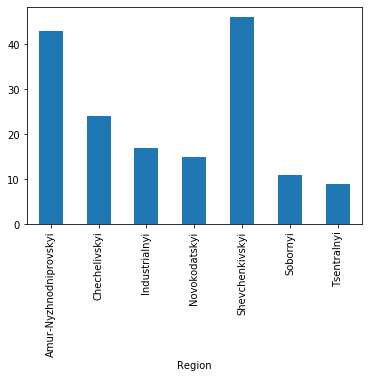

In [59]:
grouped_venues.plot.bar()

## Top-5 categories

In [60]:
dnipro_onehot = pd.get_dummies(dnipro_venues_food[['Venue Primary Category']], prefix="", prefix_sep="")
dnipro_onehot['Region'] = dnipro_venues_food['Region'] 

fixed_columns = [dnipro_onehot.columns[-1]] + list(dnipro_onehot.columns[:-1])
dnipro_onehot = dnipro_onehot[fixed_columns]

dnipro_onehot.head()

,Region,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Store,Burger Joint,Café,Caucasian Restaurant,Cocktail Bar,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Soup Place,Supermarket,Sushi Restaurant,Tea Room,Theme Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant
0,Amur-Nyzhnodniprovskyi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Amur-Nyzhnodniprovskyi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amur-Nyzhnodniprovskyi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amur-Nyzhnodniprovskyi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Amur-Nyzhnodniprovskyi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
def return_most_common_venues(row, num_top_venues):
    return row.iloc[1:].sort_values(ascending=False).index.values[0:num_top_venues]

dnipro_grouped_top_5 = dnipro_onehot.groupby('Region').sum().reset_index()

columns = ['Region']
columns.extend(['#{} Most common Venue'.format(i) for i in range(1,6)])

dnipro_grouped_top_5_sorted = pd.DataFrame(columns=columns)
dnipro_grouped_top_5_sorted['Region'] = dnipro_grouped_top_5['Region']

for ind in np.arange(dnipro_grouped_top_5.shape[0]):
    dnipro_grouped_top_5_sorted.iloc[ind, 1:] = return_most_common_venues(dnipro_grouped_top_5.iloc[ind, :], 5)
    
dnipro_grouped_top_5_sorted

,Region,#1 Most common Venue,#2 Most common Venue,#3 Most common Venue,#4 Most common Venue,#5 Most common Venue
0,Amur-Nyzhnodniprovskyi,Coffee Shop,Café,Supermarket,Fast Food Restaurant,Beer Store
1,Chechelivskyi,Café,Coffee Shop,Supermarket,Grocery Store,Restaurant
2,Industrialnyi,Bakery,Grocery Store,Eastern European Restaurant,Restaurant,Gastropub
3,Novokodatskyi,Supermarket,Grocery Store,Café,BBQ Joint,Bakery
4,Shevchenkivskyi,Coffee Shop,Modern European Restaurant,Tea Room,Bakery,Gastropub
5,Sobornyi,Restaurant,Café,Vegetarian / Vegan Restaurant,Irish Pub,Comfort Food Restaurant
6,Tsentralnyi,Coffee Shop,Restaurant,Café,Vegetarian / Vegan Restaurant,Tea Room


## Prepare data for the recommendation system

In [77]:
k_prepared_venues = dnipro_venues_food.copy()

In [78]:
k_prepared_venues = pd.concat([k_prepared_venues, dnipro_onehot.drop(columns=['Region'])], axis = 1)

In [79]:
k_prepared_venues.head()

,Region,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Primary Category,Venue Address,Venue Categories,Venue Likes,Venue Rating,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Soup Place,Supermarket,Sushi Restaurant,Tea Room,Theme Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant
0,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,48.483839,35.063883,Supermarket,"[ТРЦ ""Вавілон"" (вул. Маршала Малиновського, 2)...","[Supermarket, Grocery Store]",374,7.9,...,0,0,0,0,1,0,0,0,0,0
1,Amur-Nyzhnodniprovskyi,Pa-Si-Ju,558cfeb5498e6a17da7dfe6f,48.473249,35.029125,French Restaurant,"[просп. Дмитра Яворницького, 90, Дніпро, Україна]",[French Restaurant],231,8.4,...,0,0,0,0,0,0,0,0,0,0
2,Amur-Nyzhnodniprovskyi,HAVE Coffee,5a2fa09e69e77b22f361c493,48.469386,35.038928,Coffee Shop,"[просп. Дмитра Яворницького, 70а (вул. Юліуша ...",[Coffee Shop],80,8.4,...,0,0,0,0,0,0,0,0,0,0
3,Amur-Nyzhnodniprovskyi,Суши Набухико,5691301f498e3250c1f2ac16,48.469579,35.052557,Sushi Restaurant,"[вул. Січеславська Набережна, 31-А, Дніпро, Ук...",[Sushi Restaurant],42,8.2,...,0,0,0,0,0,1,0,0,0,0
4,Amur-Nyzhnodniprovskyi,Confetti | Конфетти,5bbefb002aff31002b5f9d9b,48.483092,35.063147,Modern European Restaurant,"[ул. Малиновского, 2, Дніпро, Україна]",[Modern European Restaurant],8,7.5,...,0,0,0,0,0,0,0,0,0,0


In [80]:
k_prepared_venues.shape

(165, 48)

### turn geolocation into the distance to my current location

In [71]:
import geocoder
g = geocoder.ip('me')

In [72]:
from geopy import distance
def calc_distance(row):
    return distance.distance(g.latlng, (row['Venue Latitude'], row['Venue Longitude'])).km

In [81]:
k_prepared_venues['Distance'] = k_prepared_venues.apply(calc_distance, axis=1)

In [82]:
k_prepared_venues.drop(columns=['Venue Latitude', 'Venue Longitude'], inplace=True)

In [91]:
new_columns = list(k_prepared_venues.columns[:8].values)
new_columns.extend(['Distance'])
new_columns.extend(k_prepared_venues.columns[8:-1].values)
k_prepared_venues = k_prepared_venues[new_columns]

In [92]:
k_prepared_venues.head()

,Region,Venue,Venue ID,Venue Primary Category,Venue Address,Venue Categories,Venue Likes,Venue Rating,Distance,Venue Is Open,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Soup Place,Supermarket,Sushi Restaurant,Tea Room,Theme Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant
0,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,Supermarket,"[ТРЦ ""Вавілон"" (вул. Маршала Малиновського, 2)...","[Supermarket, Grocery Store]",374,7.9,3.307693,False,...,0,0,0,0,1,0,0,0,0,0
1,Amur-Nyzhnodniprovskyi,Pa-Si-Ju,558cfeb5498e6a17da7dfe6f,French Restaurant,"[просп. Дмитра Яворницького, 90, Дніпро, Україна]",[French Restaurant],231,8.4,1.702071,False,...,0,0,0,0,0,0,0,0,0,0
2,Amur-Nyzhnodniprovskyi,HAVE Coffee,5a2fa09e69e77b22f361c493,Coffee Shop,"[просп. Дмитра Яворницького, 70а (вул. Юліуша ...",[Coffee Shop],80,8.4,1.121841,False,...,0,0,0,0,0,0,0,0,0,0
3,Amur-Nyzhnodniprovskyi,Суши Набухико,5691301f498e3250c1f2ac16,Sushi Restaurant,"[вул. Січеславська Набережна, 31-А, Дніпро, Ук...",[Sushi Restaurant],42,8.2,1.540025,False,...,0,0,0,0,0,1,0,0,0,0
4,Amur-Nyzhnodniprovskyi,Confetti | Конфетти,5bbefb002aff31002b5f9d9b,Modern European Restaurant,"[ул. Малиновского, 2, Дніпро, Україна]",[Modern European Restaurant],8,7.5,3.208433,NaN,...,0,0,0,0,0,0,0,0,0,0


In [93]:
for index, row in k_prepared_venues.iterrows():
    for cat in row['Venue Categories']:
        if not cat in k_prepared_venues.columns:
            k_prepared_venues[cat] = 0
    k_prepared_venues.loc[index, row['Venue Categories']] = 1

In [94]:
k_prepared_venues.drop(columns=['Venue Categories'], inplace=True)

In [95]:
k_prepared_venues.drop(columns=['Venue Primary Category'], inplace=True)

In [96]:
k_prepared_venues['Venue Is Open'] = k_prepared_venues['Venue Is Open'].apply(lambda x: 1 if x else 0)

### Normalize data

In [97]:
from sklearn import preprocessing

In [98]:
scaler = preprocessing.StandardScaler().fit(k_prepared_venues.iloc[:, 4:])

In [100]:
k_prepared_venues_norm = k_prepared_venues.copy()

In [101]:
k_prepared_venues_norm.iloc[:, 4:] = scaler.transform(k_prepared_venues.iloc[:, 4:].astype(float))

In [112]:
k_prepared_venues_norm.head()

,Region,Venue,Venue ID,Venue Address,Venue Likes,Venue Rating,Distance,Venue Is Open,Asian Restaurant,BBQ Joint,...,Bistro,Miscellaneous Shop,Breakfast Spot,Tailor Shop,Steakhouse,Noodle House,Wine Bar,Hotel,Shopping Mall,Convenience Store
0,Amur-Nyzhnodniprovskyi,Fozzy / Фоззи,52a6c1bc11d2f10095c778b6,"[ТРЦ ""Вавілон"" (вул. Маршала Малиновського, 2)...",1.030082,0.513881,-0.055152,-1.122619,-0.078087,-0.210485,...,-0.078087,-0.11077,-0.136083,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087
1,Amur-Nyzhnodniprovskyi,Pa-Si-Ju,558cfeb5498e6a17da7dfe6f,"[просп. Дмитра Яворницького, 90, Дніпро, Україна]",0.449239,0.802283,-0.663946,-1.122619,-0.078087,-0.210485,...,-0.078087,-0.11077,-0.136083,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087
2,Amur-Nyzhnodniprovskyi,HAVE Coffee,5a2fa09e69e77b22f361c493,"[просп. Дмитра Яворницького, 70а (вул. Юліуша ...",-0.164098,0.802283,-0.883948,-1.122619,-0.078087,-0.210485,...,-0.078087,-0.11077,-0.136083,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087
3,Amur-Nyzhnodniprovskyi,Суши Набухико,5691301f498e3250c1f2ac16,"[вул. Січеславська Набережна, 31-А, Дніпро, Ук...",-0.318448,0.686922,-0.725388,-1.122619,-0.078087,-0.210485,...,-0.078087,-0.11077,-0.136083,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087
4,Amur-Nyzhnodniprovskyi,Confetti | Конфетти,5bbefb002aff31002b5f9d9b,"[ул. Малиновского, 2, Дніпро, Україна]",-0.456550,0.283159,-0.092788,0.890774,-0.078087,-0.210485,...,-0.078087,-0.11077,-0.136083,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087,-0.078087


### Get most preferrable venue by Euclidian distance

In [113]:
#the most number of likes, the highest rating, opened, nearest, any location
user_data = [k_prepared_venues['Venue Likes'].max(), 10, 1, 0]
user_data.extend([0 for el in k_prepared_venues.columns[8:]])
user_data = pd.DataFrame([user_data])

In [114]:
user_data

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1742,10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
user_data_normalized = scaler.transform(user_data.astype(float))

In [116]:
user_data_normalized

array([[ 6.58667408,  1.72517124, -0.93014548, -1.12261925, -0.07808688,
        -0.21048467, -0.26726124, -0.15762208, -0.13608276, -0.11076976,
        -0.44232587, -0.1767767 , -0.15762208, -0.49051147, -0.13608276,
        -0.1767767 , -0.1767767 , -0.21048467, -0.11076976, -0.11076976,
        -0.07808688, -0.07808688, -0.15762208, -0.29244883, -0.07808688,
        -0.13608276, -0.07808688, -0.13608276, -0.19425717, -0.13608276,
        -0.15762208, -0.07808688, -0.30449176, -0.07808688, -0.07808688,
        -0.29244883, -0.11076976, -0.19425717, -0.11076976, -0.07808688,
        -0.11076976, -0.07808688, -0.07808688, -0.07808688, -0.07808688,
        -0.07808688, -0.11076976, -0.13608276, -0.07808688, -0.07808688,
        -0.07808688, -0.07808688, -0.07808688, -0.07808688, -0.07808688]])

In [117]:
from sklearn.metrics.pairwise import euclidean_distances

In [119]:
k_prepared_venues['Euclidian'] = euclidean_distances(k_prepared_venues.iloc[:, 4:], user_data_normalized)

In [124]:
fitting_venue = k_prepared_venues.loc[k_prepared_venues['Euclidian'] == k_prepared_venues['Euclidian'].min(), 'Venue ID'].values

In [126]:
k_prepared_venues.loc[k_prepared_venues['Venue ID'] == fitting_venue[0], ['Venue', 'Venue Address']]

,Venue,Venue Address
41,Море Пива,"[Малиновского, 48, Дніпро, Україна]"
